# Analysis of statistics of thermodynamical ERA-5 and JOANNE profiles for the design of the Botany-7 hypercube

Using the climatology ERA-5 profiles of `thl`, `qt`, `u`, `v` and `w` in the North-Atlantic trades, for the (extended) EUREC4A period, this notebook has the following objectives:
 1. Assessing the quality of the simple fit approximations of the climatology employed to design the hyperparameter space we want to investigate
 2. Choosing ranges to vary the hyperparameters over
 3. Choosing large-scale heating/moistening tendencies
 4. Assessing the scale of the impact of assumptions made in the Botany-7 runs:
 
  - That `thl` and `qt` can vary freely in the free troposphere, leading to non-zero tendencies in these quantities that may or may not be realistic
  
## Required data

The ERA5 and JOANNE data required is archived at Zenodo, [DOI: 10.5281/zenodo.7692269](https://doi.org/10.5281/zenodo.7692269). Links to the three files (~200 MB in total):

* [era52020spring.nc](https://zenodo.org/record/7692270/files/era52020spring.nc?download=1)
* [era52020spring_surf.nc](https://zenodo.org/record/7692270/files/era52020spring_surf.nc?download=1)
* [EUREC4A_JOANNE_Dropsonde-RD41_Level_4_v2.0.0.nc](https://zenodo.org/record/7692270/files/EUREC4A_JOANNE_Dropsonde-RD41_Level_4_v2.0.0.nc?download=1)

Download them to the same directory as the notebook, or set `loadPath` below to the data location.




## Import statements and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pandas as pd
import thermo
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
# plot settings
params = {
    'svg.fonttype'    : 'none',  # plot text as text - not paths or clones or other nonsense
    "xtick.labelsize" : 8, # ticks    
    'ytick.labelsize' : 8, # 
    'axes.labelsize'  : 9, # axis labels
    'legend.fontsize' : 9,
}
plt.rcParams.update(params)


### ERA-5

In [3]:
loadPath = '.'

ds  = nc.Dataset(loadPath+'/era52020spring.nc')
dss = nc.Dataset(loadPath+'/era52020spring_surf.nc')

# Spacing over which to sample the data horizontally (to reduce dataset size)
dlat = 2
dlon = 2

Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

presEJ = np.ma.getdata(ds.variables['level'][:]) * 100 # Pa
timeEJ = np.ma.getdata(ds.variables['time'][:])
latEJ  = np.ma.getdata(ds.variables['latitude'][::dlat])
lonEJ  = np.ma.getdata(ds.variables['longitude'][::dlon])

# print('time:', nc.num2date(ds['time'][:],ds['time'].units,ds['time'].calendar,only_use_python_datetimes=True))
# print('lon:', ds['latitude'][:])
# print('lat:', ds['longitude'][:])

# Dimensions (time, levels, lat, lon)
zEJ  = np.ma.getdata(ds.variables['z'][:,:,::dlat,::dlon]) / 9.086
qtEJ = np.ma.getdata(ds.variables['q'][:,:,::dlat,::dlon])
TEJ  = np.ma.getdata(ds.variables['t'][:,:,::dlat,::dlon])
qlEJ = np.ma.getdata(ds.variables['clwc'][:,:,::dlat,::dlon])
uEJ  = np.ma.getdata(ds.variables['u'][:,:,::dlat,::dlon])
vEJ  = np.ma.getdata(ds.variables['v'][:,:,::dlat,::dlon])
wEp  = np.ma.getdata(ds.variables['w'][:,:,::dlat,::dlon])

# Dimensions (time, lat, lon)
sstEJ = np.ma.getdata(dss.variables['sst'][:,::dlat,::dlon])
psEJ  = np.ma.getdata(dss.variables['sp'][:,::dlat,::dlon]) # Pa

## Conversions
thlEJ  = (1e5/presEJ[np.newaxis,:,np.newaxis,np.newaxis])**(2/7)*(TEJ - Lv/cp*qlEJ)
thlsEJ = (1e5/psEJ)**(2/7)*sstEJ # Assuming qts = qtsat and thus qls = 0.
rhoEJ = presEJ[np.newaxis,:,np.newaxis,np.newaxis]/Rd/TEJ # w = -\omega/(g\rho)
wEJ = -wEp/rhoEJ/grav
UEJ    = np.sqrt(uEJ**2 + vEJ**2)
qsEJ   = thermo.qsatur(TEJ, presEJ.reshape((1,presEJ.size,1,1)))
rhEJ   = 100*qtEJ/qsEJ
qtsEJ = thermo.qsatur(sstEJ,psEJ) # qtsurf = qsatsurf

# Mean and qu percentile of distribution, over horizontal location and time
qu = 10
zEJm    = np.mean(zEJ,axis=(0,2,3))

def mmm(data,qu):
    if len(data.shape) == 4:
        axes = (0,2,3)
    elif len(data.shape) == 3:
        axes = (0,1,2)
    elif len(data.shape) <= 2:
        axes = (0,)
    me = np.mean(data, axis=axes)
    mi = np.percentile(data, qu, axis=axes)
    ma = np.percentile(data, 100-qu, axis=axes)
    return me, mi, ma

qtEJm,  qtEJmin,  qtEJmax  = mmm(qtEJ,qu)
thlEJm, thlEJmin, thlEJmax = mmm(thlEJ,qu)
rhEJm,  rhEJmin,  rhEJmax  = mmm(rhEJ,qu)
uEJm,   uEJmin,   uEJmax   = mmm(uEJ,qu)
vEJm,   vEJmin,   vEJmax   = mmm(vEJ,qu)
UEJm,   UEJmin,   UEJmax   = mmm(UEJ,qu)
wEJm,   wEJmin,   wEJmax   = mmm(wEJ,qu)

/Users/martinjanssens/Documents/Wageningen/Patterns-in-satellite-images/Botany/CloudBotanyScripts/notebooks/thermo.py:24: RuntimeWarning: invalid value encountered in log
  return np.exp(54.842763-6763.22/T-4.21*np.log(T)+0.000367*T+
/Users/martinjanssens/Documents/Wageningen/Patterns-in-satellite-images/Botany/CloudBotanyScripts/notebooks/thermo.py:25: RuntimeWarning: invalid value encountered in log
  np.tanh(0.0415*(T-218.8))*(53.878-1331.22/T-9.44523*np.log(T)+ 0.014025*T))
/Users/martinjanssens/Documents/Wageningen/Patterns-in-satellite-images/Botany/CloudBotanyScripts/notebooks/thermo.py:28: RuntimeWarning: invalid value encountered in log
  return np.exp(9.550426-5723.265/T+3.53068*np.log(T)-0.00728332*T)


### JOANNE

In [4]:
dsj = nc.Dataset(loadPath+'/EUREC4A_JOANNE_Dropsonde-RD41_Level_4_v2.0.0.nc')

def flight_day_mean(dates_unique, var):
    var_fd = np.zeros((len(dates_unique),zj.size))
    for i in range(len(dates_unique)):
        idates = []
        for j in range(len(dates)):
            if dates[j] == dates_unique[i]:
                idates.append(j)
        
        var_fd[i,:] = np.mean(var[idates,:],axis=0)
    return var_fd

quj = 10 # Min/max percentile to plot

# get data
zj = dsj['alt'][:]
pj = dsj['p'][:]
qj = dsj['q'][:]
Tj = dsj['ta'][:]
wj = dsj['W'][:]
time = nc.num2date(dsj['circle_time'][:],dsj['circle_time'].units,dsj['circle_time'].calendar)

rhoj = pj/Rd/Tj

# Average over flight days
ids = dsj['segment_id'][:]
dates = []
dates_unique = []
for i in range(len(ids)):
    idi = ids[i]
    ac = idi.split('-')[0]
    date = idi.split('-')[1].split('_')[0]
    dates.append(date)
    if date not in dates_unique:
        dates_unique.append(date)

qfd = flight_day_mean(dates_unique, qj)
wfd = flight_day_mean(dates_unique, wj)
rhofd = flight_day_mean(dates_unique, rhoj)
    
# Get mean, min, max
qmj, qminj, qmaxj = mmm(qfd,quj)
wmj, wminj, wmaxj = mmm(wfd,quj)

## Plot profiles of the climatology

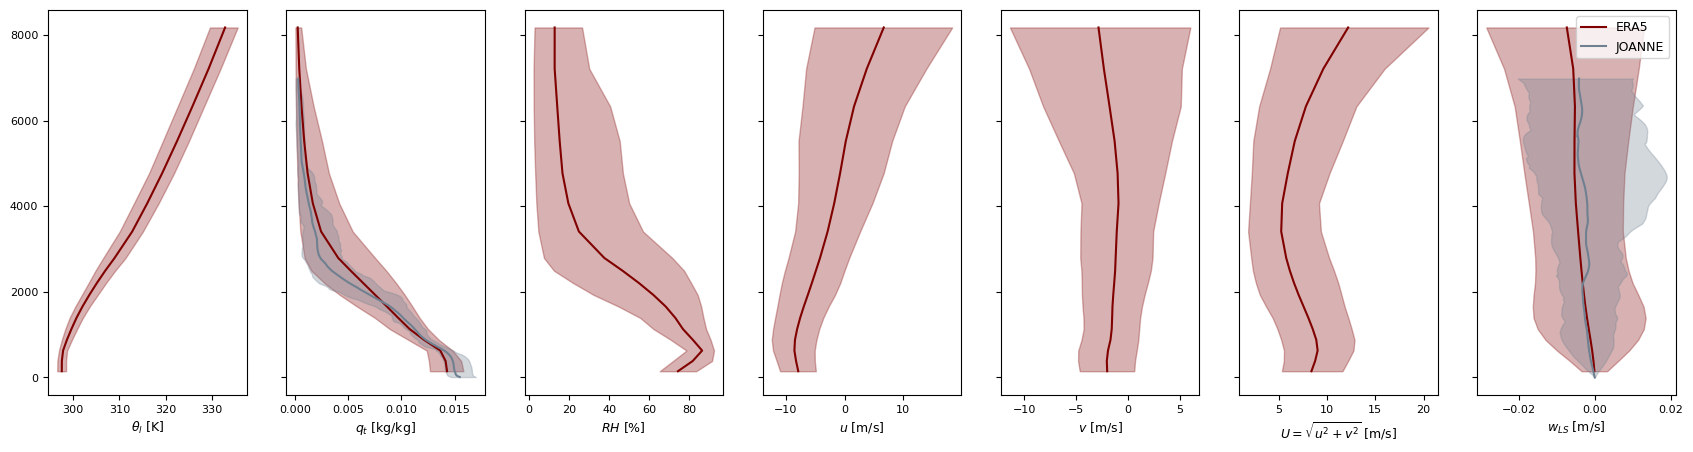

In [5]:
cs = ['midnightblue','slategrey','maroon','peru',
          'saddlebrown','gold','darkorange',
          'darkseagreen', 'teal', ]

eMax = 2 # How many levels of ERA5 to plot
jMax = 700

fig, axs = plt.subplots(ncols=7,figsize=(21,5),sharey=True)

axs[0].set_xlabel(r'$\theta_l$ [K]')
axs[0].plot(thlEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[0].fill_betweenx(zEJm[eMax:],thlEJmin[eMax:],thlEJmax[eMax:],color=cs[2],alpha=0.3)

axs[1].set_xlabel(r'$q_t$ [kg/kg]')
axs[1].plot(qtEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[1].fill_betweenx(zEJm[eMax:],qtEJmin[eMax:],qtEJmax[eMax:],color=cs[2],alpha=0.3)
axs[1].plot(qmj[1:jMax],zj[1:jMax],c=cs[1])
axs[1].fill_betweenx(zj[1:jMax],qminj[1:jMax],qmaxj[1:jMax],color=cs[1],alpha=0.3)

axs[2].set_xlabel(r'$RH$ [%]')
axs[2].plot(rhEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[2].fill_betweenx(zEJm[eMax:],rhEJmin[eMax:],rhEJmax[eMax:],color=cs[2],alpha=0.3)

axs[3].set_xlabel(r'$u$ [m/s]')
axs[3].plot(uEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[3].fill_betweenx(zEJm[eMax:],uEJmin[eMax:],uEJmax[eMax:],color=cs[2],alpha=0.3)

axs[4].set_xlabel(r'$v$ [m/s]')
axs[4].plot(vEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[4].fill_betweenx(zEJm[eMax:],vEJmin[eMax:],vEJmax[eMax:],color=cs[2],alpha=0.3)

axs[5].set_xlabel(r'$U = \sqrt{u^2+v^2}$ [m/s]')
axs[5].plot(UEJm[eMax:],zEJm[eMax:],c=cs[2])
axs[5].fill_betweenx(zEJm[eMax:],UEJmin[eMax:],UEJmax[eMax:],color=cs[2],alpha=0.3)

axs[6].set_xlabel(r'$w_{LS}$ [m/s]')
axs[6].plot(wEJm[eMax:],zEJm[eMax:],c=cs[2],label='ERA5')
axs[6].fill_betweenx(zEJm[eMax:],wEJmin[eMax:],wEJmax[eMax:],color=cs[2],alpha=0.3)
axs[6].plot(wmj[:jMax],zj[:jMax],c=cs[1],label='JOANNE')
axs[6].fill_betweenx(zj[:jMax],wminj[:jMax],wmaxj[:jMax],color=cs[1],alpha=0.3)

axs[6].legend(loc='best',bbox_to_anchor=(1,1))
plt.savefig('exps.pdf',bbox_inches='tight')
plt.show()

## 1. Assessing quality of idealised profile fits

In [6]:
## Functions

# Linear profile, fixed shear
def linu(z, u0, dudz=0.00222):
    return u0 + dudz*z

# Linear profile, fixed shear
def linv(z, u0, dudz):
    return u0 + dudz*z

# Linear profile with mixed layer, with mixed layer value based on surface value (u0) minus offset
def linml(z, u0, dudz, du0=1.25, zml=500):
    u = np.zeros(z.shape)
    u[z<=zml] = u0 - du0 # Positive offsets are reductions w.r.t surface
    u[z>zml] = u0 - du0 + (z[z>zml] - zml)*dudz
    return u

# Exponential decay with mixed layer, where qt0 is set at zml
def exp(z, u0, u_lambda, zml=500):
    u = u0 * np.exp(-(z-zml) / u_lambda)
    if type(u0) == float:
        u[z<=zml] = u0
    elif u0.ndim < 2:
        u[z<=zml] = u0
    elif u0.ndim == 2:
        z  = z .reshape(z.size)
        u0 = u0.reshape(u0.size)
        for i in range(u0.size):
            u[z<=zml,i] = u0[i]
    else:
        print('Dimension of input u0 not supported, mixed layer not added')
    return u

# First mode of vertical velocity - exponential decay with Hadley cell
def w_0(z, w0, hw0):
    psi0 = (1-np.exp(-z/hw0))
    return psi0*w0

# Second mode of vertical velocity - mesoscale circulation
def w_1(z, w1, hw1):
    psi1 = np.sin(2.*np.pi/hw1*z)
    psi1[z>hw1] = 0.
    return psi1*w1

# Sum of first and second modes of vertical velocity - with fixed w0, hw0, hw1
def w_01(z, w1, w0=-0.0045, hw0=2500, hw1=5300):
    return w_0(z, w0, hw0) + w_1(z, w1, hw1)

# Compute rh for profile
def rhProf(thl0, dthldz, qt0, qt_lambda, z, pres=presEJ, du=1.25, zml=500):
    thl = linmlsurf(z, dthldz, thl0, du=du, zml=zml)
    qt  = exp(z, qt0 , qt_lambda)
    T, ql = thermo.T_and_ql(thl, qt, pres)    
    qs = thermo.qsatur(T,pres)
    return 100*qt/qs

### ERA-5 database analysis

In [7]:
# Loop over all profiles -> store results in DataFrame (This may take 5-10 min)
try:
    # load a cached copy if it exists from a previous run
    df = pd.read_hdf(loadPath+'/simpleparams-botany-7.h5')
except:
    df = pd.DataFrame(columns=['time','lat','lon','thls','dthldz','qt0','hqt',
                               'u0','v0','dvdz','w1',
                               'vthls','vdthldz', 'rthl',
                               'vqt0','vhqt', 'rqt',
                               'vu0', 'ru',
                               'vv0','vdvdz', 'rv',
                               'vw1', 'rw'
                               ],
                      index=np.arange(len(timeEJ)*len(latEJ)*len(lonEJ)),
                      dtype='float64')

    ind = 0
    for i in range(len(timeEJ)):
        for j in range(len(latEJ)):
            for k in range(len(lonEJ)):

                # Fit curves
                [thls,dthldz], pcth = curve_fit(linml, zEJ[i,eMax:,j,k], 
                                                thlEJ[i,eMax:,j,k], 
                                                p0=[300,0.004])
                qof_thl = pearsonr(thlEJ[i,eMax:,j,k], linml(zEJ[i,eMax:,j,k], thls, dthldz))[0]**2

                [qt0,hqt], pcqt = curve_fit(exp, zEJ[i,eMax:,j,k],
                                            qtEJ[i,eMax:,j,k],
                                            p0=[0.016,1500])
                qof_qt = pearsonr(qtEJ[i,eMax:,j,k], exp(zEJ[i,eMax:,j,k], qt0, hqt))[0]**2

                u0, pcu = curve_fit(linu, zEJ[i,eMax:,j,k],
                                           uEJ[i,eMax:,j,k],
                                           p0=[-10])

                qof_u = pearsonr(uEJ[i,eMax:,j,k], linu(zEJ[i,eMax:,j,k], u0))[0]**2

                [v0,dvdz], pcv = curve_fit(linv, zEJ[i,eMax:,j,k],
                                           vEJ[i,eMax:,j,k])
                qof_v = pearsonr(vEJ[i,eMax:,j,k], linv(zEJ[i,eMax:,j,k], v0, dvdz))[0]**2

                try:
                    # Almost always breaks
                    w1, pcw = curve_fit(w_01, zEJ[i,eMax:,j,k],
                                                     wEJ[i,eMax:,j,k],
                                                     p0=-0.0025)
                    qof_w = pearsonr(wEJ[i,eMax:,j,k], w_01(zEJ[i,eMax:,j,k], w1))[0]**2
                except:
                    print('Error raised by curvefit, setting nans')
                    w1 = np.nan
                    pcw = np.nan
                    qof_w = np.nan

                # Write to df
                df.loc[ind,'time'] = timeEJ[i]
                df.loc[ind,'lat']  = latEJ[j]
                df.loc[ind,'lon']  = lonEJ[k]
                df.loc[ind,'thls'] = thls
                df.loc[ind,'dthldz'] = dthldz
                df.loc[ind,'qt0'] = qt0
                df.loc[ind,'hqt'] = hqt
                df.loc[ind,'u0'] = u0
                df.loc[ind,'v0'] = v0
                df.loc[ind,'dvdz'] = dvdz
                df.loc[ind,'w1'] = w1
                df.loc[ind,'vthls'] = pcth[0,0]
                df.loc[ind,'vdthldz'] = pcth[1,1]
                df.loc[ind,'vqt0'] = pcqt[0,0]
                df.loc[ind,'vhqt'] = pcqt[1,1]
                df.loc[ind,'vu0'] = pcu
                df.loc[ind,'vv0'] = pcv[0,0]
                df.loc[ind,'vdvdz'] = pcv[1,1]
                df.loc[ind,'vw1'] = pcw
                df.loc[ind,'rthl'] = qof_thl
                df.loc[ind,'rqt'] = qof_qt
                df.loc[ind,'ru'] = qof_u
                df.loc[ind,'rv'] = qof_v
                df.loc[ind,'rw'] = qof_w

                ind += 1

                if ind%100 == 0:
                    print('Done', ind, ' / ', df.shape[0])

    df.to_hdf(loadPath+'/simpleparams-botany-7.h5','simpleparams',mode='w')



In [8]:
# Quantifying:
#    i) error in the estimated parameters through linear regression, 
#   ii) variability over fit data set,
#  iii) co-variability among the parameters,
#   iv) magnitude of v0 relative to u0 to assess underestimation of (horizontal) momentum

est = [ 'thls', 'dthldz', 'qt0', 'hqt', 'u0', 'v0', 'dvdz', 'w1']
# err = ['vthls','vdthldz','vqt0','vhqt','vu0','vv0','vdvdz','vw1']
err = ['rthl', 'rqt', 'ru', 'rv', 'rw']

dfest = df[est]
# snr   = np.array(dfest)/np.array(dferr)
# dfsnr = pd.DataFrame(data=snr,columns=est)
dferr = df[err].mean()

print('Mean par. value:')
# print(np.mean(dfest))
print(dfest.mean())
print('10-90\%:')
print(np.percentile(df[est], 10, axis=0), np.percentile(df[est], 90, axis=0))
print('Mean r2 (assuming linearity):')
print(dferr)
print('v0/u0:', np.mean(dfest['v0']/dfest['u0']))
print(dfest.corr())

Mean par. value:
thls       298.489544
dthldz       0.004849
qt0          0.014728
hqt       1959.662334
u0         -10.682756
v0          -1.442187
dvdz        -0.000049
w1           0.000393
dtype: float64
10-90\%:
[ 2.97449671e+02  4.40292792e-03  1.34139169e-02  1.34989600e+03
 -1.44399995e+01 -4.82698856e+00 -1.12136998e-03 -9.84303121e-03] [ 2.99546834e+02  5.23322557e-03  1.60756054e-02  2.63083215e+03
 -6.87727669e+00  1.76770362e+00  1.13129834e-03  1.14229147e-02]
Mean r2 (assuming linearity):
rthl    0.985706
rqt     0.951528
ru      0.716437
rv      0.443337
rw      0.284820
dtype: float64
v0/u0: 0.1445277145845474
            thls    dthldz       qt0       hqt        u0        v0      dvdz  \
thls    1.000000 -0.313701  0.332429  0.103625  0.124582  0.131262  0.089271   
dthldz -0.313701  1.000000  0.021712 -0.264486  0.012394  0.155146 -0.275458   
qt0     0.332429  0.021712  1.000000  0.345372 -0.054388  0.248672 -0.179951   
hqt     0.103625 -0.264486  0.345372  1.00000

### JOANNE analysis (for w variability, which is deficient in ERA-5 fits)

In [9]:
zjmin = 20   # Lowest level to take data from
zjcth = 2500 # Approximate cloud-top height (i.e. including inversion layer)
zjmax = 7000 # Profile fit top height
qutwpp = 50  # Where to separate moist/dry
ququ = 25    # Where to draw envelopes of moist/dry

qpj = qfd - qmj[np.newaxis,:]
wpj = wfd - wmj[np.newaxis,:]

izjmin = np.argmin(np.abs(zj-zjmin))
izjcth = np.argmin(np.abs(zj-zjcth))
izjmax = np.argmin(np.abs(zj-zjmax))

# Circle moisture fluctuations per m^2
twppj = np.trapz(rhofd[:,izjmin:izjcth]*qpj[:,izjmin:izjcth],zj[izjmin:izjcth],axis=1)

# indices of moistest/driest qu%
imoist = np.where(twppj >= np.percentile(twppj,100-qutwpp))[0]
idry = np.where(twppj <= np.percentile(twppj,qutwpp))[0]

# q, w in moist/dry circles
qpmm,qpmmin,qpmmax = mmm(qpj[imoist], ququ)
wpmm,wpmmin,wpmmax = mmm(wpj[imoist], ququ)
qpdm,qpdmin,qpdmax = mmm(qpj[idry], ququ)
wpdm,wpdmin,wpdmax = mmm(wpj[idry], ququ)

/Users/martinjanssens/opt/anaconda3/envs/botany_env/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Moist region [w0m,hw0m,w1m,hw1m] [-0.002992961367230811, 757.3139080446347, 0.0022162109090119895, 6106.784561405024]
Dry region [w0d,hw0d,w1d,hw1d] [-12.327956853570463, 15519798.138576047, -0.0036604649024855225, 5351.787467997728]


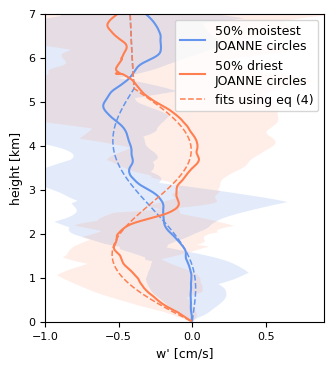

In [10]:
# Plot - Figure 1
# Let's use the JOANNE data's moistest and driest circle structure as indication of what is "typical" 
# for the circulating mode

[w1m,w0m,hw0m,hw1m], pcov = curve_fit(w_01, zj[izjmin:izjmax], (wmj+wpmm)[izjmin:izjmax],
                                      p0=[0.0025,-4e-3,1000,7500]) 
[w1d,w0d,hw0d,hw1d], pcov = curve_fit(w_01, zj[izjmin:izjmax], (wmj+wpdm)[izjmin:izjmax],
                                      p0=[-0.0035,-5e-3,2500,7500])

print('Moist region [w0m,hw0m,w1m,hw1m]',[w0m,hw0m,w1m,hw1m])
print('Dry region [w0d,hw0d,w1d,hw1d]',[w0d,hw0d,w1d,hw1d])

# With only the amplitude varying:
w0m = -0.0045; w0d = -0.0045
hw0m = 2500; hw0d = 2500
w1m = 0.0018; w1d = -0.0035
hw1m = 5300; hw1d = 5300

col_moist = 'cornflowerblue'
col_dry   = 'coral'

fig, axs = plt.subplots(ncols=1,figsize=(3.6,4))
axs.plot((wmj+wpmm)[izjmin:izjmax]*100,zj[izjmin:izjmax]/1000,
         c=col_moist,label="%.0f%% moistest\nJOANNE circles"%qutwpp)
axs.plot(w_01(zj[izjmin:izjmax],w1m,w0m,hw0m,hw1m)*100,zj[izjmin:izjmax]/1000,
         c=col_moist,linestyle='--', lw=1.1)
axs.fill_betweenx(zj[izjmin:izjmax]/1000,(wmj+wpmmin)[izjmin:izjmax]*100,(wmj+wpmmax)[izjmin:izjmax]*100,
                  color=col_moist,alpha=0.18,edgecolor='none')
axs.plot((wmj+wpdm)[izjmin:izjmax]*100,zj[izjmin:izjmax]/1000,
         c=col_dry, label="%.0f%% driest\nJOANNE circles"%qutwpp)
axs.plot(w_01(zj[izjmin:izjmax],w1d,w0d,hw0d,hw1d)*100,zj[izjmin:izjmax]/1000,
         c=col_dry, linestyle='--', lw=1.1, label='fits using eq (4)')
axs.fill_betweenx(zj[izjmin:izjmax]/1000,(wmj+wpdmin)[izjmin:izjmax]*100,(wmj+wpdmax)[izjmin:izjmax]*100,
                  color=col_dry,alpha=0.13,edgecolor='none')
axs.set_xlabel(r"w' [cm/s]")
axs.set_ylabel(r"height [km]")
axs.set_xlim((-0.9,0.9))
axs.set_xticks((-1, -.5, 0, .5))
axs.set_ylim((0,zj[izjmax]/1000))
axs.legend(loc='upper right') # bbox_to_anchor=(1,1)
plt.savefig(loadPath+'/wls_bot7_joanne.pdf',bbox_inches='tight')

## 2. Selecting parameter ranges

In [11]:
# BOTANY-7 DESIGN TABLE
# ran7 = ran6.copy()
qu = 10 # Baseline values are 10-90 percentiles
eMax = 4

# Baseline table (free parameters)
par = [ 'thls', 'dthldz', 'qt0', 'hqt', 'u0', 'w1']
mi = np.percentile(df[par], qu, axis=0)
ma = np.percentile(df[par], 100-qu, axis=0)
ran7 = pd.DataFrame(columns=par,data=np.vstack((mi,ma)))

## thl

# Use thls instead of SST
ran7['thls'] = [297.5, 299.5]

# Round the lapse rates
ran7['dthldz'] = [0.0045, 0.0055]

# Add constant temperature parameters to the table
ran7['dthl0'] = 1.25
ran7['zml'] = 500

## qt

# Modify from baseline to keep from being artificially dry or saturating (see next cell for RH plots)
ran7['qt0'] = [0.0135,0.015]
ran7['hqt'] = [1200,2500]

# u
ran7['u0'] = [-15.0,-5.0] # Rounded from 10-90 values
ran7['dudz'] = 0.00222

# w -> From JOANNE
ran7['w0'] = -0.0045
ran7['hw0'] = 2500
ran7['w1'] = [-0.0035,0.0018]
ran7['hw1'] = 5300

print(ran7)

    thls  dthldz     qt0   hqt    u0      w1  dthl0  zml     dudz      w0  \
0  297.5  0.0045  0.0135  1200 -15.0 -0.0035   1.25  500  0.00222 -0.0045   
1  299.5  0.0055  0.0150  2500  -5.0  0.0018   1.25  500  0.00222 -0.0045   

    hw0   hw1  
0  2500  5300  
1  2500  5300  


In [12]:
# Plots of parameter ranges

# Simulation grid, from case-setup-botany.py
alpha = 1.01  #  dz = 15m at surface, 30m @ 1500m
Nz = 175      #  top at 7km
dz = 15
z_b7 = np.zeros(Nz)
z_b7[0] = dz/2
dz_ = dz
for i in range(1,Nz):
    z_b7[i] = z_b7[i-1] + dz_
    dz_ *= alpha

pinterp = interp1d(np.append(zEJm,0), np.append(presEJ,101605))

# cube centre
thls_c = 298.5
dthldz_c = 0.005
u0_c = -10
qt0_c = 0.01425
hqt_c = 1850
w1_c = -0.00085

thl_c = linml(z_b7, thls_c, dthldz_c, du0=ran7['dthl0'].iloc[0], zml=ran7['zml'].iloc[0])
qt_c = exp(z_b7, qt0_c, hqt_c, zml=ran7['zml'][0])
u_c = linu(z_b7, u0_c, ran7['dudz'].iloc[0])
w_c = w_01(z_b7, w1_c, ran7['w0'].iloc[0],ran7['hw0'].iloc[0],ran7['hw1'].iloc[0])

T_c, ql_c = thermo.T_and_ql(thl_c, qt_c, pinterp(z_b7))
qs_c    = thermo.qsatur(T_c,pinterp(z_b7))
rh_c = 100*qt_c/qs_c

# thl corners
thl_b7 = np.zeros((z_b7.size,4))
for i in range(len(ran7['thls'])):
    for j in range(len(ran7['dthldz'])):
        thl_b7[:,i*2+j] = linml(z_b7, ran7['thls'].iloc[i], ran7['dthldz'].iloc[j],
                                  du0=ran7['dthl0'].iloc[0], zml=ran7['zml'].iloc[0])

# thls sweep
thls_sw = np.array([297.5, 298.5, 299.5, 300.5, 301.5])
thl_sw_s = np.zeros((z_b7.size, thls_sw.size))
for i in range(len(thls_sw)):
    thl_sw_s[:,i] = linml(z_b7, thls_sw[i], dthldz_c,
                          du0=ran7['dthl0'].iloc[0], zml=ran7['zml'].iloc[0])        
# dthldz sweep
dthldz_sw = np.array([4.0, 4.5, 4.75, 5.0, 5.25, 5.5])*1e-3
thl_sw_dthldz = np.zeros((z_b7.size,dthldz_sw.size))
for i in range(len(dthldz_sw)):
    thl_sw_dthldz[:,i] = linml(z_b7, thls_c, dthldz_sw[i],
                               du0=ran7['dthl0'].iloc[0], zml=ran7['zml'].iloc[0])

# qt corners
qt_b7 = np.zeros((z_b7.size,4))
for i in range(len(ran7['qt0'])):
    for j in range(len(ran7['hqt'])):
        qt_b7[:,i*2+j] = exp(z_b7, ran7['qt0'].iloc[i], ran7['hqt'].iloc[j], zml=ran7['zml'][0])

# qt0 sweep
qt0_sw = np.array([0.0135, 0.01425, 0.015])
qt_sw_0 = np.zeros((z_b7.size, qt0_sw.size))
for i in range(len(qt0_sw)):
    qt_sw_0[:,i] = exp(z_b7, qt0_sw[i], hqt_c, zml=ran7['zml'][0])

qth_sw = np.array([800, 1200, 1500, 1850, 2200, 2500, 3000])
qt_sw_h = np.zeros((z_b7.size, qth_sw.size))
for i in range(len(qth_sw)):
    qt_sw_h[:,i] = exp(z_b7, qt0_c, qth_sw[i], zml=ran7['zml'][0])

# rh -> Every combination of thl (4) and qt (2)
rh_b7 = np.zeros((z_b7.size,thl_b7.shape[1]*qt_b7.shape[1]))
for i in range(thl_b7.shape[1]):
    for j in range(qt_b7.shape[1]):
        T, ql = thermo.T_and_ql(thl_b7[:,i], qt_b7[:,j], pinterp(z_b7))
        qs    = thermo.qsatur(T,pinterp(z_b7))
        rh_b7[:,i*4+j] = 100*qt_b7[:,j]/qs
        print('Max RH:', np.max(rh_b7[:,i*2+j]))

# u corners
u_b7 = np.zeros((z_b7.size,2))
for i in range(len(ran7['u0'])):
    u_b7[:,i] = linu(z_b7, ran7['u0'].iloc[i], ran7['dudz'].iloc[i])

# u sweep
u0_sw = np.array([-4.0, -6.0, -8.0, -10.0, -12.0])
u_sw = np.zeros((z_b7.size,u0_sw.size))
for i in range(len(u0_sw)):
    u_sw[:,i] = linu(z_b7, u0_sw[i], ran7['dudz'].iloc[0])

# dudz sweep
dudz_sw = np.array([-0.0011, 0, 0.0011, 0.0022, 0.0033, 0.0044])
u_sw_dudz = np.zeros((z_b7.size,dudz_sw.size))
for i in range(len(dudz_sw)):
    u_sw_dudz[:,i] = linu(z_b7, u0_c, dudz_sw[i])

# w corners
w_b7 = np.zeros((z_b7.size,2))
for i in range(w_b7.shape[1]):
    w_b7[:,i] = w_01(z_b7,ran7['w1'].iloc[i],ran7['w0'].iloc[0],ran7['hw0'].iloc[0],ran7['hw1'].iloc[0])
    
# w sweep
w1_sw = np.array([-0.002, -0.001, 0.0, 0.001])
w_sw = np.zeros((z_b7.size,w1_sw.size))
for i in range(len(w1_sw)):
    w_sw[:,i] = w_01(z_b7, w1_sw[i], ran7['w0'].iloc[0],ran7['hw0'].iloc[0],ran7['hw1'].iloc[0])

Max RH: 88.43000613477702
Max RH: 88.66483367892897
Max RH: 98.25554244568683
Max RH: 98.5164616708186
Max RH: 98.25554244568683
Max RH: 98.5164616708186
Max RH: 88.43000613477702
Max RH: 88.61407115557272
Max RH: 88.43000613477702
Max RH: 88.61407115557272
Max RH: 98.25554244568683
Max RH: 98.46005891163466
Max RH: 98.25554244568683
Max RH: 98.46005891163466
Max RH: 78.20849492333758
Max RH: 78.4124503762564


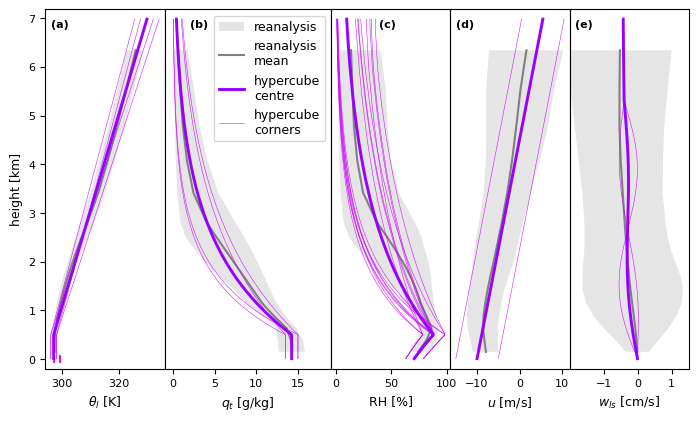

In [13]:
# Plot - Figure 2

lw  = 0.4 # corners
lws = 0.6 # sweep
lwc = 2.1
# the sweeps are commented out below, for less clutter

cs = ['gray','blue','blueviolet','limegreen']
cs = ['gray',(0.6,0,1),(0.8,0,1,.9),'limegreen']


fig, axs = plt.subplots(ncols=5,figsize=(8.3, 7*2/3), 
                        sharey=True, gridspec_kw={'width_ratios':[1,1.4,1,1,1]}) 

axs[0].set_xlabel(r'$\theta_l$ [K]')
axs[0].set_ylabel('height [km]')
axs[0].set_ylim((-200,z_b7.max()+200))
axs[0].plot(thlEJm[eMax:],zEJm[eMax:]/1000,c=cs[0],zorder=1) # rean center
axs[0].fill_betweenx(zEJm[eMax:]/1000,thlEJmin[eMax:],thlEJmax[eMax:],
                     color=cs[0],alpha=0.2,label='reanalysis',edgecolor='none') 
axs[0].plot(thl_c, z_b7/1000, c=cs[1], label='centre',lw=lwc,zorder=5) # cube center
axs[0].scatter(ran7['thls'],[0.,0.],marker='|',color=cs[2],s=30)
for i in range(thl_b7.shape[1]):
    label = 'hypercube\ncorners' if i == 0 else None
    axs[0].plot(thl_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw,label=label)
#for i in range(thl_sw_dthldz.shape[1]):
#    label = 'sweep' if i == 0 else None
#    axs[0].plot(thl_sw_dthldz[:,i],z_b7/1000,color=cs[3],linewidth=lws,label=label)
#for i in range(thl_sw_s.shape[1]):
#    axs[0].plot(thl_sw_s[:,i],z_b7/1000,color=cs[3],linewidth=lws)
#axs[0].scatter(thls_sw,np.zeros(len(thls_sw)),marker='|',color=cs[3],s=10)
    
axs[1].set_xlabel(r'$q_t$ [g/kg]')
axs[1].set_ylim((-.200,z_b7.max()/1000+.200))
axs[1].set_xlim((-1,19))
axs[1].fill_betweenx(zEJm[eMax:]/1000,qtEJmin[eMax:]*1e3,qtEJmax[eMax:]*1e3,
                     color=cs[0],alpha=0.2,label='reanalysis',edgecolor='none')
axs[1].plot(qtEJm[eMax:]*1e3,zEJm[eMax:]/1000,c=cs[0],label='reanalysis\nmean')
axs[1].plot(qt_c*1e3,z_b7/1000,c=cs[1],label='hypercube\ncentre',lw=lwc,zorder=5)
for i in range(qt_b7.shape[1]):
    label = 'hypercube\ncorners' if i == 0 else None
    axs[1].plot(qt_b7[:,i]*1e3,z_b7/1000,color=cs[2],linewidth=lw,label=label)
#for i in range(qt_sw_0.shape[1]):
#    label = 'sweep' if i == 0 else None
#    axs[1].plot(qt_sw_0[:,i]*1e3,z_b7/1000,color=cs[3],linewidth=lws,label=label)
#for i in range(qt_sw_h.shape[1]):
#    axs[1].plot(qt_sw_h[:,i]*1e3,z_b7/1000,color=cs[3],linewidth=lws)

axs[2].set_xlabel(r'RH [%]')
axs[2].set_ylim((-.200,z_b7.max()/1000+.200))
axs[2].plot(rhEJm[eMax:],zEJm[eMax:]/1000,c=cs[0])
axs[2].fill_betweenx(zEJm[eMax:]/1000,rhEJmin[eMax:],rhEJmax[eMax:],
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[2].plot(rh_c,z_b7/1000,c=cs[1],lw=lwc,zorder=5)
for i in range(rh_b7.shape[1]):
    axs[2].plot(rh_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw)
    
axs[3].set_xlabel(r'$u$ [m/s]')
axs[3].set_ylim((-.200,z_b7.max()/1000+.200))
axs[3].plot(uEJm[eMax:],zEJm[eMax:]/1000,c=cs[0])
axs[3].fill_betweenx(zEJm[eMax:]/1000,uEJmin[eMax:],uEJmax[eMax:],
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[3].plot(u_c,z_b7/1000,c=cs[1],lw=lwc,zorder=5)
for i in range(u_b7.shape[1]):
    axs[3].plot(u_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw)
#for i in range(u_sw.shape[1]):
#    axs[3].plot(u_sw[:,i],z_b7/1000,color=cs[3],linewidth=lws)
#for i in range(u_sw_dudz.shape[1]):
#    axs[3].plot(u_sw_dudz[:,i],z_b7/1000,color=cs[3],linewidth=lws)

axs[4].set_xlabel(r'$w_{ls}$ [cm/s]')
axs[4].set_ylim((-.200,z_b7.max()/1000+.200))
axs[4].set_xlim((-2,1.5))
axs[4].set_xticks((-1, 0, 1))
axs[4].plot(wEJm[eMax:]*1e2,zEJm[eMax:]/1000,c=cs[0])
axs[4].fill_betweenx(zEJm[eMax:]/1000,wEJmin[eMax:]*1e2,wEJmax[eMax:]*1e2,
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[4].plot(w_c*1e2, z_b7/1000, c=cs[1],lw=lwc,zorder=5)
for i in range(w_b7.shape[1]):
    axs[4].plot(w_b7[:,i]*1e2,z_b7/1000,color=cs[2],linewidth=lw)
#for i in range(w_sw.shape[1]):
#    axs[4].plot(w_sw[:,i]*1e2,z_b7/1000,color=cs[3],linewidth=lws)
    
axs[1].legend(loc='best')

for i in range(1,5):
    # remove tick marks from y axis of inner plots
    axs[i].tick_params(left=False)
    
plt.subplots_adjust(wspace=.0, hspace=.0) 

for i,ax in enumerate(axs):
    label=f'({chr(ord("a")+i)})'
    x=0.05
    if i == 1:
        x = 0.15
    if i == 2:
        x = 0.4
    label_text = ax.text(x, 0.95, label, size=8, weight='bold', color='black', transform=ax.transAxes)

plt.savefig(loadPath+'/prof_b7.pdf',bbox_inches='tight')
plt.show()

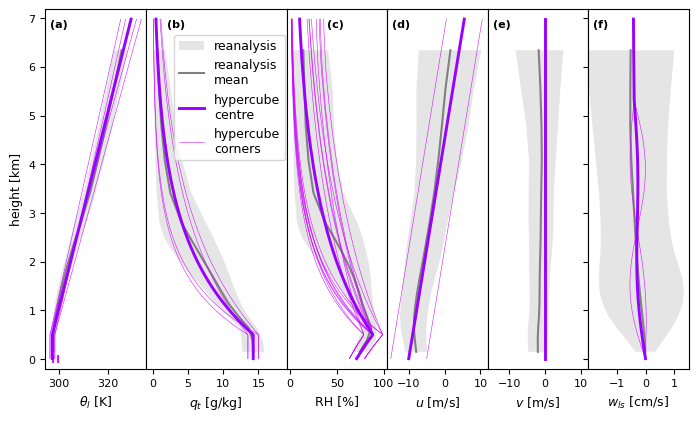

In [14]:
# Plot - Figure 2 alternative including v

lw  = 0.4 # corners
lws = 0.6 # sweep
lwc = 2.1
# the sweeps are commented out below, for less clutter

cs = ['gray','blue','blueviolet','limegreen']
cs = ['gray',(0.6,0,1),(0.8,0,1,.9),'limegreen']


fig, axs = plt.subplots(ncols=6,figsize=(8.3, 7*2/3), 
                        sharey=True, gridspec_kw={'width_ratios':[1,1.4,1,1,1,1]}) 

axs[0].set_xlabel(r'$\theta_l$ [K]')
axs[0].set_ylabel('height [km]')
axs[0].set_ylim((-200,z_b7.max()+200))
axs[0].plot(thlEJm[eMax:],zEJm[eMax:]/1000,c=cs[0],zorder=1) # rean center
axs[0].fill_betweenx(zEJm[eMax:]/1000,thlEJmin[eMax:],thlEJmax[eMax:],
                     color=cs[0],alpha=0.2,label='reanalysis',edgecolor='none') 
axs[0].plot(thl_c, z_b7/1000, c=cs[1], label='centre',lw=lwc,zorder=5) # cube center
axs[0].scatter(ran7['thls'],[0.,0.],marker='|',color=cs[2],s=30)
for i in range(thl_b7.shape[1]):
    label = 'hypercube\ncorners' if i == 0 else None
    axs[0].plot(thl_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw,label=label)
#for i in range(thl_sw_dthldz.shape[1]):
#    label = 'sweep' if i == 0 else None
#    axs[0].plot(thl_sw_dthldz[:,i],z_b7/1000,color=cs[3],linewidth=lws,label=label)
#for i in range(thl_sw_s.shape[1]):
#    axs[0].plot(thl_sw_s[:,i],z_b7/1000,color=cs[3],linewidth=lws)
#axs[0].scatter(thls_sw,np.zeros(len(thls_sw)),marker='|',color=cs[3],s=10)
    
axs[1].set_xlabel(r'$q_t$ [g/kg]')
axs[1].set_ylim((-.200,z_b7.max()/1000+.200))
axs[1].set_xlim((-1,19))
axs[1].fill_betweenx(zEJm[eMax:]/1000,qtEJmin[eMax:]*1e3,qtEJmax[eMax:]*1e3,
                     color=cs[0],alpha=0.2,label='reanalysis',edgecolor='none')
axs[1].plot(qtEJm[eMax:]*1e3,zEJm[eMax:]/1000,c=cs[0],label='reanalysis\nmean')
axs[1].plot(qt_c*1e3,z_b7/1000,c=cs[1],label='hypercube\ncentre',lw=lwc,zorder=5)
for i in range(qt_b7.shape[1]):
    label = 'hypercube\ncorners' if i == 0 else None
    axs[1].plot(qt_b7[:,i]*1e3,z_b7/1000,color=cs[2],linewidth=lw,label=label)
#for i in range(qt_sw_0.shape[1]):
#    label = 'sweep' if i == 0 else None
#    axs[1].plot(qt_sw_0[:,i]*1e3,z_b7/1000,color=cs[3],linewidth=lws,label=label)
#for i in range(qt_sw_h.shape[1]):
#    axs[1].plot(qt_sw_h[:,i]*1e3,z_b7/1000,color=cs[3],linewidth=lws)

axs[2].set_xlabel(r'RH [%]')
axs[2].set_ylim((-.200,z_b7.max()/1000+.200))
axs[2].plot(rhEJm[eMax:],zEJm[eMax:]/1000,c=cs[0])
axs[2].fill_betweenx(zEJm[eMax:]/1000,rhEJmin[eMax:],rhEJmax[eMax:],
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[2].plot(rh_c,z_b7/1000,c=cs[1],lw=lwc,zorder=5)
for i in range(rh_b7.shape[1]):
    axs[2].plot(rh_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw)
    
axs[3].set_xlabel(r'$u$ [m/s]')
axs[3].set_xlim((-16,12))
axs[3].set_ylim((-.200,z_b7.max()/1000+.200))
axs[3].plot(uEJm[eMax:],zEJm[eMax:]/1000,c=cs[0])
axs[3].fill_betweenx(zEJm[eMax:]/1000,uEJmin[eMax:],uEJmax[eMax:],
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[3].plot(u_c,z_b7/1000,c=cs[1],lw=lwc,zorder=5)
for i in range(u_b7.shape[1]):
    axs[3].plot(u_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw)
#for i in range(u_sw.shape[1]):
#    axs[3].plot(u_sw[:,i],z_b7/1000,color=cs[3],linewidth=lws)
#for i in range(u_sw_dudz.shape[1]):
#    axs[3].plot(u_sw_dudz[:,i],z_b7/1000,color=cs[3],linewidth=lws)

axs[4].set_xlabel(r'$v$ [m/s]')
axs[4].set_xlim((-16,12))
axs[4].set_ylim((-.200,z_b7.max()/1000+.200))
axs[4].plot(vEJm[eMax:],zEJm[eMax:]/1000,c=cs[0])
axs[4].fill_betweenx(zEJm[eMax:]/1000,vEJmin[eMax:],vEJmax[eMax:],
                     color=cs[0],alpha=0.2,edgecolor='none')
v_c = np.zeros_like(z_b7)
axs[4].plot(v_c,z_b7/1000,c=cs[1],lw=lwc,zorder=5)
#for i in range(v_b7.shape[1]):
#    axs[4].plot(v_b7[:,i],z_b7/1000,color=cs[2],linewidth=lw)
    

axs[5].set_xlabel(r'$w_{ls}$ [cm/s]')
axs[5].set_ylim((-.200,z_b7.max()/1000+.200))
axs[5].set_xlim((-2,1.5))
axs[5].set_xticks((-1, 0, 1))
axs[5].plot(wEJm[eMax:]*1e2,zEJm[eMax:]/1000,c=cs[0])
axs[5].fill_betweenx(zEJm[eMax:]/1000,wEJmin[eMax:]*1e2,wEJmax[eMax:]*1e2,
                     color=cs[0],alpha=0.2,edgecolor='none')
axs[5].plot(w_c*1e2, z_b7/1000, c=cs[1],lw=lwc,zorder=5)
for i in range(w_b7.shape[1]):
    axs[5].plot(w_b7[:,i]*1e2,z_b7/1000,color=cs[2],linewidth=lw)
#for i in range(w_sw.shape[1]):
#    axs[5].plot(w_sw[:,i]*1e2,z_b7/1000,color=cs[3],linewidth=lws)
    
axs[1].legend(loc=(0.2,0.58))

for i in range(1,5):
    # remove tick marks from y axis of inner plots
    axs[i].tick_params(left=False)
    
plt.subplots_adjust(wspace=.0, hspace=.0) 

for i,ax in enumerate(axs):
    label=f'({chr(ord("a")+i)})'
    x=0.05
    if i == 1:
        x = 0.15
    if i == 2:
        x = 0.4
    label_text = ax.text(x, 0.95, label, size=8, weight='bold', color='black', transform=ax.transAxes)

plt.savefig(loadPath+'/prof_b7v.pdf',bbox_inches='tight')
plt.show()

## 3. Advective tendencies

In [15]:
quj = 25

# Load necessary variables from JOANNE
uj = dsj['u'][:]
vj = dsj['v'][:]
thj = Tj*(1e5/pj)**(2/7) # Equal thl if the circle is unsaturated

dqdxj = dsj['dqdx']
dqdyj = dsj['dqdy']
dqdtls = -(uj*dqdxj + vj*dqdyj)

dTdxj = dsj['dtadx']
dTdyj = dsj['dtady']
dpdxj = dsj['dpdx']
dpdyj = dsj['dpdy']

dthdxj = (1e5/pj)**(2/7)*dTdxj + thj/pj*dpdxj
dthdyj = (1e5/pj)**(2/7)*dTdyj + thj/pj*dpdyj

dthdtls = -(uj*dthdxj + vj*dthdyj)

dqdtlsfd = flight_day_mean(dates_unique, dqdtls)
dthdtlsfd = flight_day_mean(dates_unique, dthdtls)

# Using flight days
dqdtlsm, dqdtlsmin, dqdtlsmax = mmm(dqdtlsfd,quj)
dthdtlsm, dthdtlsmin, dthdtlsmax = mmm(dthdtlsfd,quj)

/Users/martinjanssens/opt/anaconda3/envs/botany_env/lib/python3.8/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/Users/martinjanssens/opt/anaconda3/envs/botany_env/lib/python3.8/site-packages/numpy/ma/core.py:1013: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)
/Users/martinjanssens/opt/anaconda3/envs/botany_env/lib/python3.8/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


In [16]:
# Make simple fits

# large-scale moistening and heating due to advection
def lin(z, u0, dudz):
    return u0 + dudz*z 

# HEATING
thlpls0 = -5.78e-06
dthlplsdz = -thlpls0/2000

dthldtls = lin(z_b7, thlpls0, dthlplsdz)
dthldtls[dthldtls>0] = 0

# MOISTENING
qtpls0 = -1.73e-08
dqtplsdz = -qtpls0/4000

dqtdtls = lin(z_b7, qtpls0, dqtplsdz)
dqtdtls[dqtdtls>0] = 0


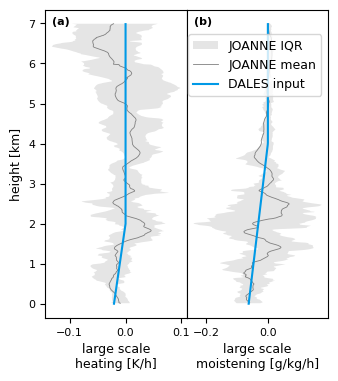

In [17]:
# Plot - Figure 3

fig, axs = plt.subplots(ncols=2,figsize=(3.65,4),sharey=True)
cd = (0,0.6,0.9)

axs[0].set_xlabel("large scale\nheating [K/h]")
axs[0].set_ylabel('height [km]')
axs[0].fill_betweenx(zj[izjmin:izjmax]/1000,dthdtlsmin[izjmin:izjmax]*3600,dthdtlsmax[izjmin:izjmax]*3600,
                     color='k',alpha=0.1,label='JOANNE IQR',edgecolor='none')
axs[0].plot(dthdtlsm[izjmin:izjmax]*3600,zj[izjmin:izjmax]/1000,'gray',lw=0.6)
axs[0].plot(dthldtls*3600,z_b7/1000,c=cd)

axs[1].set_xlabel("large scale\nmoistening [g/kg/h]")
axs[1].fill_betweenx(zj[izjmin:izjmax]/1000,dqdtlsmin[izjmin:izjmax]*1000*3600,dqdtlsmax[izjmin:izjmax]*1000*3600,
                     color='k',alpha=0.1,label='JOANNE IQR',edgecolor='none')
axs[1].plot(dqdtlsm[izjmin:izjmax]*1000*3600,zj[izjmin:izjmax]/1000,'gray',lw=0.6,label='JOANNE mean')
axs[1].plot(dqtdtls*1000*3600,z_b7/1000,c=cd,label='DALES input')
#axs[1].set_xlim([-.29,0.15])
axs[1].legend(loc=(0.01,0.72))

axs[1].tick_params(left=False)
plt.subplots_adjust(wspace=.0)

for i,ax in enumerate(axs):
    label=f'({chr(ord("a")+i)})'
    label_text = ax.text(0.05, 0.95, label, size=8, weight='bold', color='black', transform=ax.transAxes)

plt.savefig(loadPath+'/ls-bot7.pdf',bbox_inches='tight')


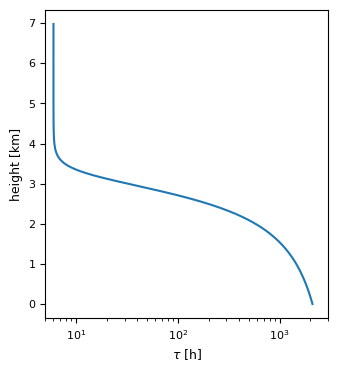

In [18]:
# Figure 4 - nudging time scale tau(z)

def nudge_atan(x, a=5, b=2, c=20, lev_max_change=3000, end=3600*6):
    """	
    Nudging timescale creation, by Alessandro Savazzi. Free-tropospheric
    nudging time set by end parameter (default is 6 hours), with the max
    gradient in nudging time occurring at lev_max_change.
    """
    y = b * (np.pi/2+np.arctan(a * np.pi/2 * (1-x/lev_max_change)))
    y = end + y**c    
    return y

tau = nudge_atan(z_b7, a=2, b=3, c=7.4, lev_max_change=3000, end=3600*6) / 3600
# nudging time in hours

fig, axs = plt.subplots(ncols=1,figsize=(3.65,4),sharey=True)
plt.xscale('log')
plt.xlim([5,3000])
plt.plot(tau, z_b7/1000)
axs.set_ylabel('height [km]')
axs.set_xlabel(r'$\tau$ [h]')

plt.savefig(loadPath+'/tau.pdf',bbox_inches='tight')
